# Are Amazon product reviews generally more positive/negative for certain categories compared to others?

TODOS:
Sentiment Analysis Markdown Text
Hinzufügen zu General Notebook
Summary schreiben

In [24]:
import pyspark.pandas as ps
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf, count, col, coalesce, lit, avg, concat_ws, mean, stddev, var_samp, expr
from pyspark.sql.types import StringType, DoubleType
from pyspark.sql import SparkSession
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # Not in Requirements, poetry add vaderSentiment
from textblob import TextBlob

spark = SparkSession.builder.master('local[*]').config("spark.driver.memory", "6g").config("spark.executor.memory", "6g").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","12g").getOrCreate()

data = spark.read.parquet('/data/data.parquet', index_col=['reviewerID', 'asin'])
print(f"Shape of the DataFrame: ({data.count()}, {len(data.columns)})")

Shape of the DataFrame: (230139802, 27)


## Outlier Detection and Handling
Interestingly, the dataset contains 9 rows, all having an overall star rating of 0 stars. However, when considering the vast size of the entire dataset, which consists of 230,139,802 rows, these 9 entries are realistically insignificant. As a result, we have excluded them from our analysis. Including them would only serve to complicate the plots and data without providing any meaningful additional information gain. Additionally, looking at the review summary of those rows, classifies them even more as outliers, because the text 'Goog Read' would typically not result in a rating of 0 stars.

In [25]:
data[data['overall'] == 0.0][['overall', 'summary', 'reviewText']].show()
data = data.filter(data['overall'] != 0.0)

+-------+--------------------+--------------------+
|overall|             summary|          reviewText|
+-------+--------------------+--------------------+
|    0.0|Blurb from inside...|The fundamental s...|
|    0.0|Old world knowled...|From the back cov...|
|    0.0|              Rating|The story was goo...|
|    0.0|A pretty little book|A pretty little b...|
|    0.0|Vividly colored r...|This is the artis...|
|    0.0|           Good Read|Beneath a Scarlet...|
|    0.0|           Good Read|Beneath a Scarlet...|
|    0.0|                Wow!|I cried throughou...|
|    0.0|            Readable|A lot of mistakes...|
+-------+--------------------+--------------------+



## Star Ratings Analysis
To address the question of whether Amazon reviews exhibit a tendency to be more positive or negative across different categories, we chose to compare them using two metrics. The first metric examines the overall star rating of the reviews, investigating for example whether certain categories receive more 5-star reviews than others and examining the general distribution of star ratings.

### Data Preparation
After handling outliers, a star rating can now range from 1 star to 5 stars, with 5 stars representing the highest rating. To facilitate meaningful comparisons across different categories, we computed the total number of reviews for each possible star rating and the average rating for each category.

In [5]:
##
## Groups by Category and counts the number of ratings per Star Rating
## Returned Columns: 'category', 'stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5', 'number_of_reviews', 'average_rating'
## Returned Dataframe is a Pandas Dataframe
##
def reduce_to_cat_stars(data):
    long_df = data.groupBy('category', 'overall').count()
    df = long_df.groupBy('category').pivot('overall').sum("count")

    for i in range(1, 6):
        df = df.withColumnRenamed(f"{i}.0", f"stars_{i}")

    df = df.withColumn('number_of_reviews', col('stars_1') + col('stars_2') + col('stars_3') + col('stars_4') + col('stars_5'))
    df = df.withColumn('average_rating', (col('stars_1') + col('stars_2') * 2 + col('stars_3') * 3 + col('stars_4') * 4 + col('stars_5') * 5) / col('number_of_reviews'))

    df = df.orderBy('category')
    return df.toPandas()


data_cat_stars = reduce_to_cat_stars(data)
data_cat_stars

,category,stars_1,stars_2,stars_3,stars_4,stars_5,number_of_reviews,average_rating
0,AMAZON_FASHION,107080,64718,97031,149331,465476,883636,3.906940
1,All_Beauty,39261,20293,29555,52687,229549,371345,4.112093
2,Appliances,59627,20734,30652,75476,416288,602777,4.274209
3,Arts_Crafts_and_Sewing,210232,120994,198200,361840,1984651,2875917,4.317731
4,Automotive,734047,329578,503860,1065868,5356813,7990166,4.249263
5,Books,2088314,1850688,3835225,9557650,33979736,51311613,4.393248
6,CDs_and_Vinyl,165396,133374,277854,700943,3265802,4543369,4.489727
7,Cell_Phones_and_Accessories,1382543,654327,860610,1517552,5648223,10063255,3.933553
8,Clothing_Shoes_and_Jewelry,2271737,1804553,2982765,5707951,19525093,32292099,4.189458
9,Digital_Music,43108,23551,57347,179929,1280147,1584082,4.660555


### Plot and Review the Results
The following plot illustrates the percentage of reviews for each category corresponding to a specific star rating. Additionally, the categories are arranged in order of their average star rating, facilitating the identification of significant differences in star rating distribution. For instance, Gift Cards, Digital Music, and CDs and Vinyl exhibit relatively high average star ratings with a substantial number of 5-star reviews, in contrast to categories like Software and Fashion products.

This disparity may arise from the nature of products such as Gift Cards and Digital Music, where issues are less likely to occur. Gift cards usually function seamlessly upon purchase, minimizing the likelihood of dissatisfaction leading to negative reviews. Similarly, with Digital Music and CDs and Vinyl, the ease of access to online music and the likelihood that purchasers genuinely enjoy the songs they buy contribute to higher satisfaction levels.

On the other hand, Software faces challenges like a high error rate, installation difficulties, and configuration complexities, which may result in a less favorable experience for users.

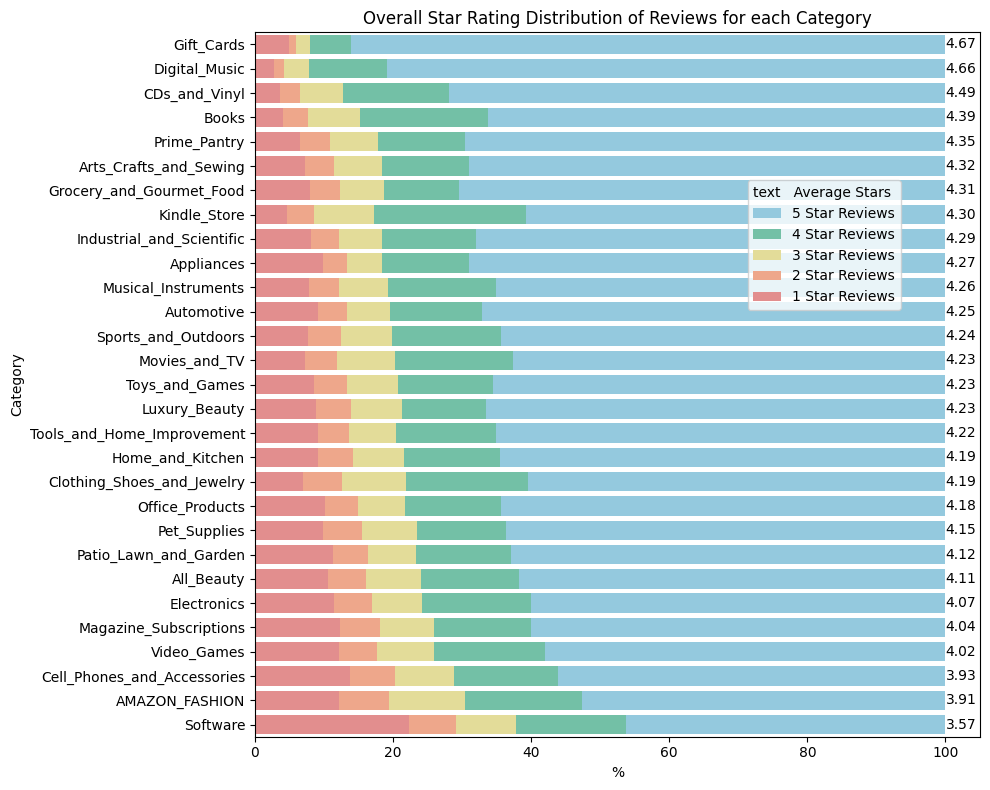

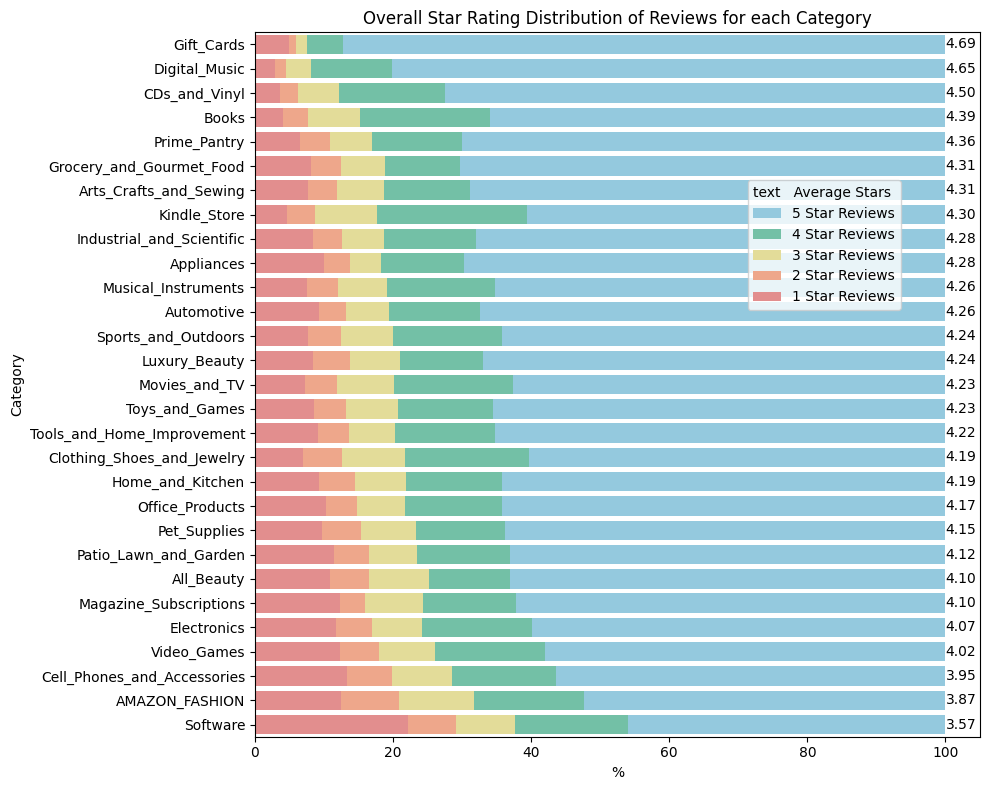

In [23]:
def plot_cat_stars(df_cat_stars):
    # Calculate comulative values
    com_df_cat_stars = df_cat_stars.copy()
    for i in range(1, 5):
        com_df_cat_stars[f'stars_{i+1}'] += com_df_cat_stars[f'stars_{i}']
    # Normalize and convert to Percent
    for i in range(1, 6):
        com_df_cat_stars[f'stars_{i}'] *= 100 / com_df_cat_stars[f'stars_5']

    com_df_cat_stars = com_df_cat_stars.sort_values(by=['average_rating'], ascending=False).reset_index(drop=True)

    # Pastel-toned colors
    pastel_palette = ["#87CEEB", "#66CDAA", "#F0E68C", "#FFA07A", "#F08080"]

    # Plotting the stacked horizontal bar plot with pastel-toned colors
    plt.figure(figsize=(10, 8))
    ax1 = sns.barplot(x='stars_5', y='category', data=com_df_cat_stars, orient='h', color=pastel_palette[0], label='5 Star Reviews')
    sns.barplot(x='stars_4', y='category', data=com_df_cat_stars, orient='h', color=pastel_palette[1], label='4 Star Reviews')
    sns.barplot(x='stars_3', y='category', data=com_df_cat_stars, orient='h', color=pastel_palette[2], label='3 Star Reviews')
    sns.barplot(x='stars_2', y='category', data=com_df_cat_stars, orient='h', color=pastel_palette[3], label='2 Star Reviews')
    sns.barplot(x='stars_1', y='category', data=com_df_cat_stars, orient='h', color=pastel_palette[4], label='1 Star Reviews')

    # Annotate each bar with the corresponding average rating value
    for i, row in com_df_cat_stars.iterrows():
        ax1.text(row['stars_5'], i, f'{row["average_rating"]:.2f}', ha='left', va='center', color='black')

    # Customize plot labels and title
    ax1.set_xlabel('%')
    ax1.set_ylabel('Category')
    ax1.set_title('Overall Star Rating Distribution of Reviews for each Category')

    # Tight layout and legend
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(0.9, 0.8), title='text   Average Stars', alignment='left')

    # Show the plot
    plt.show()

plot_cat_stars(data_cat_stars)
plot_cat_stars(reduce_to_cat_stars(data_sample))

## Sentiment Analysis
In addition to considering the star ratings, we also examined the positive and negative sentiment of the reviews for each category. Unfortunately, the Sentiment Analysis tool from Vader (https://vadersentiment.readthedocs.io/en/latest/) is computationally very intensive, and as a result, it was only performed on a sample of the data. Conversely, the TextBlob Text Processing tool (https://textblob.readthedocs.io/en/dev/) is more efficient in terms of computation, allowing us to calculate sentiment scores for the entire dataset.

### Sampling the Dataset

Beschreibung warum so gesampled wird

In [6]:
categories = sorted([row['category'] for row in data.select('category').distinct().collect()])

In [7]:
##
## Creates a sample of each category based on the star ratings, it therefore tries to follow the distribution of the star ratings in the original dataset as closely as possible
##
def sample_for_sentiment(filename, spark_session, frac = 0.00001, min_per_cat = 1000, verbose = False):
    mode = 'overwrite'
    for category in categories:
        if verbose:
            print(f"Currently subsampling category {category} ...")
        rows_of_category = spark_session.read.parquet(f'/data/{category}.parquet')
        rows_of_category = rows_of_category[['category', 'overall', 'verified', 'summary', 'reviewText']].dropna()

        frac = max(frac, min_per_cat / rows_of_category.count())
        fractions = {stars: frac for stars in range(1, 6)}
        sampled_rows = rows_of_category.sampleBy('overall', fractions, seed=42)

        sampled_rows.write.parquet(filename, mode=mode)
        mode = 'append'

filename = '/data/question1_data_sample.parquet'
sample_for_sentiment(filename, spark)
data_sample = spark.read.parquet(filename)

reduce_to_cat_stars(data_sample)

,category,stars_1,stars_2,stars_3,stars_4,stars_5,number_of_reviews,average_rating
0,AMAZON_FASHION,129,87,112,165,542,1035,3.873430
1,All_Beauty,110,57,88,118,638,1011,4.104847
2,Appliances,166,62,73,201,1152,1654,4.276300
3,Arts_Crafts_and_Sewing,591,327,537,963,5338,7756,4.306086
4,Automotive,1990,853,1335,2841,14552,21571,4.256873
5,Books,5691,4920,10391,25868,91087,137957,4.389853
6,CDs_and_Vinyl,445,322,722,1888,8865,12242,4.503512
7,Cell_Phones_and_Accessories,3619,1775,2343,4062,15287,27086,3.945987
8,Clothing_Shoes_and_Jewelry,6044,4858,7989,15502,52312,86705,4.190012
9,Digital_Music,127,64,158,498,3432,4279,4.646179


Beschreibung warum in 0.6, 0.2, -0.2 und -0.6 eingeteilt wird

In [8]:
##
## Removes unnecaccary columns and adds column for the sentiment analysis
##
def reduce_to_sentiment(df, calculate_score, score_col):
    df = df.withColumn('text', concat_ws(' - ', col('summary'), col('reviewText')))
    df = df.withColumn(score_col, calculate_score(df['text']))

    df = df[['category', 'overall', 'verified', score_col]]
    calculate_sentiment = udf(lambda compound: 'very_positive' if compound >= 0.6 
                                else ('positive' if compound >= 0.2
                                else ('very_negative' if compound <= -0.6 
                                else ('negative' if compound <= -0.2
                                else 'neutral'))), StringType())
    df = df.withColumn("sentiment", calculate_sentiment(df[score_col]))
    return df

def write_sentiment_parque(filename, spark_session, calculate_score, score_col):
    mode = 'overwrite'
    for category in categories:
        if verbose:
            print(f"Currently subsampling category {category} ...")
        rows_of_category = spark_session.read.parquet(f'/data/{category}.parquet')
        rows_of_category = rows_of_category[['category', 'overall', 'verified', 'summary', 'reviewText']].dropna()

        sentiment_rows = reduce_to_sentiment(rows_of_category, calculate_score, score_col)

        sentiment_rows.write.parquet(filename, mode=mode)
        mode = 'append'

### Data Preparation Vader Sentiment

In [12]:
## New Columns: 'vader_compound', 'sentiment'
def reduce_to_vader_sentiment(df):
    calculate_score = udf(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['compound'] if x else 0, DoubleType())
    col_name = 'vader_compound'
    return reduce_to_sentiment(df, calculate_score, col_name)

def write_vader_sentiment(filename, spark_session):
    calculate_score = udf(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['compound'] if x else 0, DoubleType())
    col_name = 'vader_compound'
    return write_sentiment_parque(filename, spark_session, calculate_score, col_name)

filename = '/data/question1_data_sample_vader_sentiment.parquet'

# data_sample_vader_sentiment = reduce_to_vader_sentiment(data_sample)
# data_sample_vader_sentiment.write.parquet(filename, mode = 'overwrite')

data_sample_vader_sentiment = spark.read.parquet(filename)

### Data Preparation TextBlob

In [13]:
## New Columns: 'textblob_polarity', 'sentiment'
def reduce_to_textblob_sentiment(df):
    calculate_score = udf(lambda x: TextBlob(x).polarity if x else 0, DoubleType())
    col_name = 'textblob_polarity'
    return reduce_to_sentiment(df, calculate_score, col_name)

def write_textblob_sentiment(filename, spark_session):
    calculate_score = udf(lambda x: TextBlob(x).polarity if x else 0, DoubleType())
    col_name = 'textblob_polarity'
    return write_sentiment_parque(filename, spark_session, calculate_score, col_name)

filename = '/data/question1_data_sample_textblob_sentiment.parquet'

# data_sample_textblob_sentiment = reduce_to_textblob_sentiment(data_sample)
# data_sample_textblob_sentiment.write.parquet(filename, mode = 'overwrite')

data_sample_textblob_sentiment = spark.read.parquet(filename)

Due to the fact that TextBlob Polarity Analysis is much faster than the Vader Sentiment, we conducted the analysis over the whole dataset.

In [17]:
filename = '/data/question1_data_complete_textblob_sentiment.parquet'
# write_textblob_sentiment(filename, spark)
data_textblob_sentiment = spark.read.parquet(filename)

### Plot and Review the Results

In [18]:
##
## Groups by Category and counts the number of ratings per sentiment class
## Resulting Columns: 'category', 'very_negative', 'negative', 'neutral', 'positive', 'very_positive', 'number_of_reviews', 'average_sentiment'
##
def reduce_to_cat_sentiment(data, score_col):
    long_df = data.groupBy('category', 'sentiment').count()
    df = long_df.groupBy('category').pivot('sentiment').sum("count")
    df = df.withColumn('number_of_reviews', col('very_negative') + col('negative') + col('neutral') + col('positive') + col('very_positive'))

    df = df.orderBy('category').toPandas()
    average_sentiment = data.groupBy("category").agg(avg(score_col).alias('average_sentiment')).toPandas().reset_index(drop=True)
    df = df.merge(average_sentiment, on='category', how='left')

    return df

data_sample_vader_cat_sentiment = reduce_to_cat_sentiment(data_sample_vader_sentiment, 'vader_compound')
data_sample_textblob_cat_sentiment = reduce_to_cat_sentiment(data_sample_textblob_sentiment, 'textblob_polarity')

data_textblob_cat_sentiment = reduce_to_cat_sentiment(data_textblob_sentiment, 'textblob_polarity')

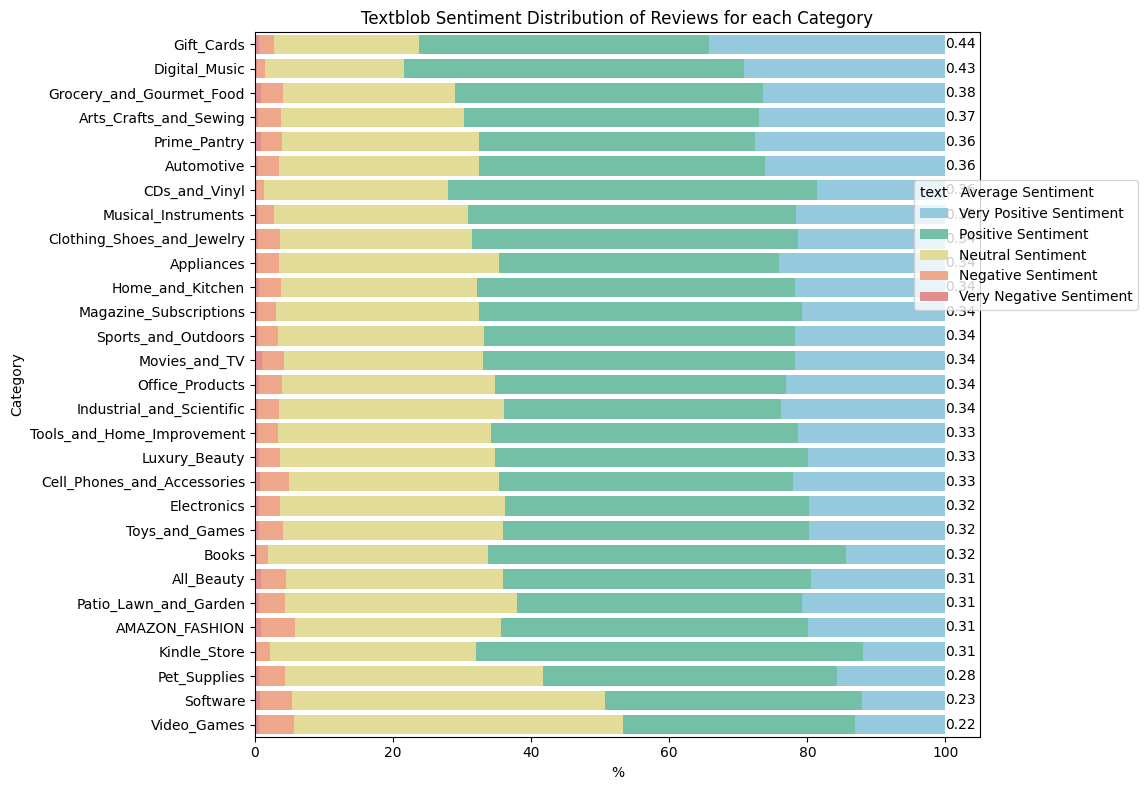

In [19]:
def plot_cat_sentiment(title, df_cat_sentiment):
    # Calculate comulative values
    com_df_cat_sentiment = df_cat_sentiment.copy()
    sentiments = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']
    for i in range(0, 4):
        com_df_cat_sentiment[sentiments[i+1]] += com_df_cat_sentiment[sentiments[i]]
    # Normalize and convert to Percent
    for i in range(0, 5):
        com_df_cat_sentiment[sentiments[i]] *= 100 / com_df_cat_sentiment[sentiments[4]]


    com_df_cat_sentiment = com_df_cat_sentiment.sort_values(by=['average_sentiment'], ascending=False).reset_index(drop=True)

    # Pastel-toned colors
    pastel_palette = ["#87CEEB", "#66CDAA", "#F0E68C", "#FFA07A", "#F08080"]

    # Plotting the stacked horizontal bar plot with pastel-toned colors
    plt.figure(figsize=(10, 8))
    ax1 = sns.barplot(x='very_positive', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[0], label='Very Positive Sentiment')
    sns.barplot(x='positive', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[1], label='Positive Sentiment')
    sns.barplot(x='neutral', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[2], label='Neutral Sentiment')
    sns.barplot(x='negative', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[3], label='Negative Sentiment')
    sns.barplot(x='very_negative', y='category', data=com_df_cat_sentiment, orient='h', color=pastel_palette[4], label='Very Negative Sentiment')

    # Annotate each bar with the corresponding average rating value
    for i, row in com_df_cat_sentiment.iterrows():
        ax1.text(row['very_positive'], i, f'{row["average_sentiment"]:.2f}', ha='left', va='center', color='black')

    # Customize plot labels and title
    ax1.set_xlabel('%')
    ax1.set_ylabel('Category')
    ax1.set_title(title)

    # Tight layout and legend
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(0.9, 0.8), title='text   Average Sentiment', alignment='left')


    # Show the plot
    plt.show()

plot_cat_sentiment('Textblob Sentiment Distribution of Reviews for each Category', data_textblob_cat_sentiment)

## Comparison between Vader Sentiment and TextBlob 

In [28]:
def compare_stats(data, textblob_data, sample, textblob_sample):
    summary_data = data.groupby('category').agg(
        mean('overall').alias('mean'),
        var_samp('overall').alias('var'),
        count('overall').alias('n')).toPandas()

    summary_data = summary_data.merge(textblob_data[['category', 'average_sentiment']], on='category', how='left')
    summary_data.rename(columns={'average_sentiment': 'textblob'}, inplace=True)

    summary_sample = data_sample.groupby('category').agg(
        mean('overall').alias('mean'),
        var_samp('overall').alias('var'),
        count('overall').alias('n')).toPandas()

    summary_sample = summary_sample.merge(textblob_sample[['category', 'average_sentiment']], on='category', how='left')
    summary_sample.rename(columns={'average_sentiment': 'textblob'}, inplace=True)

    result_df = summary_data.merge(summary_sample, on='category', how='inner', suffixes=('_data', '_sample'))
    
    result_df['mean_diff'] = (result_df['mean_data'] - result_df['mean_sample']).abs()
    result_df['var_diff'] = (result_df['var_data'] - result_df['var_sample']).abs()
    result_df['textblob_diff'] = (result_df['textblob_data'] - result_df['textblob_sample']).abs()
    result_df = result_df.sort_values(by=['category'], ascending=True).reset_index(drop=True)
    result_df = result_df.sort_index(axis=1)
    
    return result_df   

stats = compare_stats(data, data_textblob_cat_sentiment, data_sample, data_sample_textblob_cat_sentiment)
stats

,category,mean_data,mean_diff,mean_sample,n_data,n_sample,textblob_data,textblob_diff,textblob_sample,var_data,var_diff,var_sample
0,AMAZON_FASHION,3.906940,0.033510,3.873430,883636,1035,0.311714,0.004756,0.306958,2.011517,0.064324,2.075841
1,All_Beauty,4.112093,0.007246,4.104847,371345,1011,0.314065,0.004891,0.318957,1.855312,0.058436,1.913749
2,Appliances,4.274209,0.002091,4.276300,602777,1654,0.343185,0.001045,0.344230,1.694155,0.024376,1.718531
3,Arts_Crafts_and_Sewing,4.317731,0.011645,4.306086,2875917,7756,0.372555,0.000433,0.372988,1.484252,0.034169,1.518421
4,Automotive,4.249263,0.007609,4.256873,7990166,21571,0.360737,0.001051,0.361788,1.663165,0.004117,1.659048
5,Books,4.393248,0.003395,4.389853,51311613,137957,0.315036,0.000916,0.314119,1.092881,0.004639,1.097520
6,CDs_and_Vinyl,4.489727,0.013785,4.503512,4543369,12242,0.357439,0.000921,0.358360,0.985187,0.023146,0.962041
7,Cell_Phones_and_Accessories,3.933553,0.012434,3.945987,10063255,27086,0.325097,0.000552,0.324545,2.138930,0.026249,2.112682
8,Clothing_Shoes_and_Jewelry,4.189458,0.000554,4.190012,32292099,86705,0.343948,0.000048,0.343900,1.517789,0.006918,1.510871
9,Digital_Music,4.660555,0.014376,4.646179,1584082,4279,0.429375,0.006919,0.422456,0.712389,0.036165,0.748554


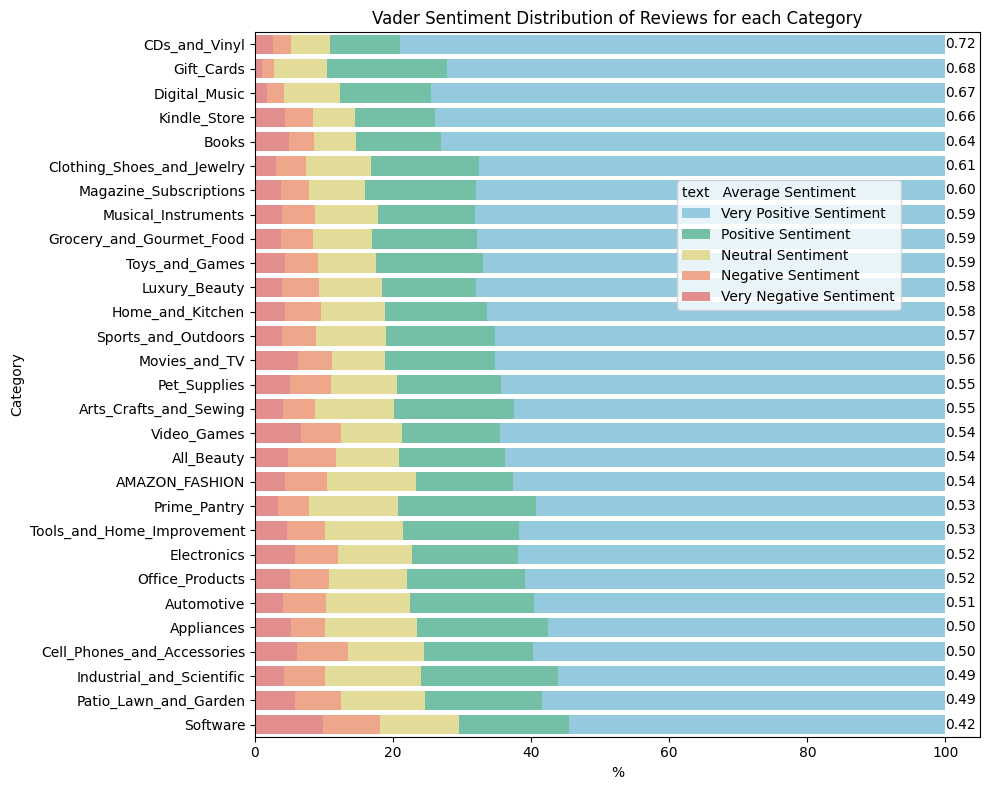

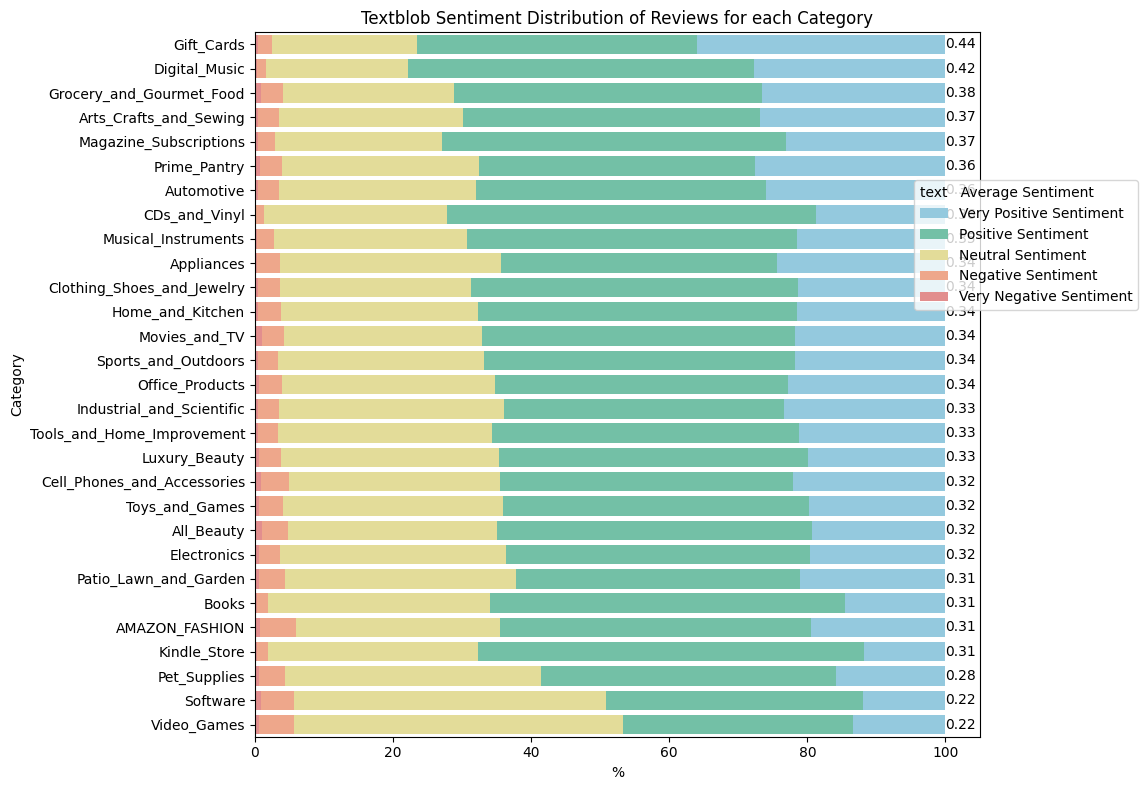

In [20]:
plot_cat_sentiment('Vader Sentiment Distribution of Reviews for each Category', data_sample_vader_cat_sentiment)
plot_cat_sentiment('Textblob Sentiment Distribution of Reviews for each Category', data_sample_textblob_cat_sentiment)



## Korrelation between Star Rating and Sentiment

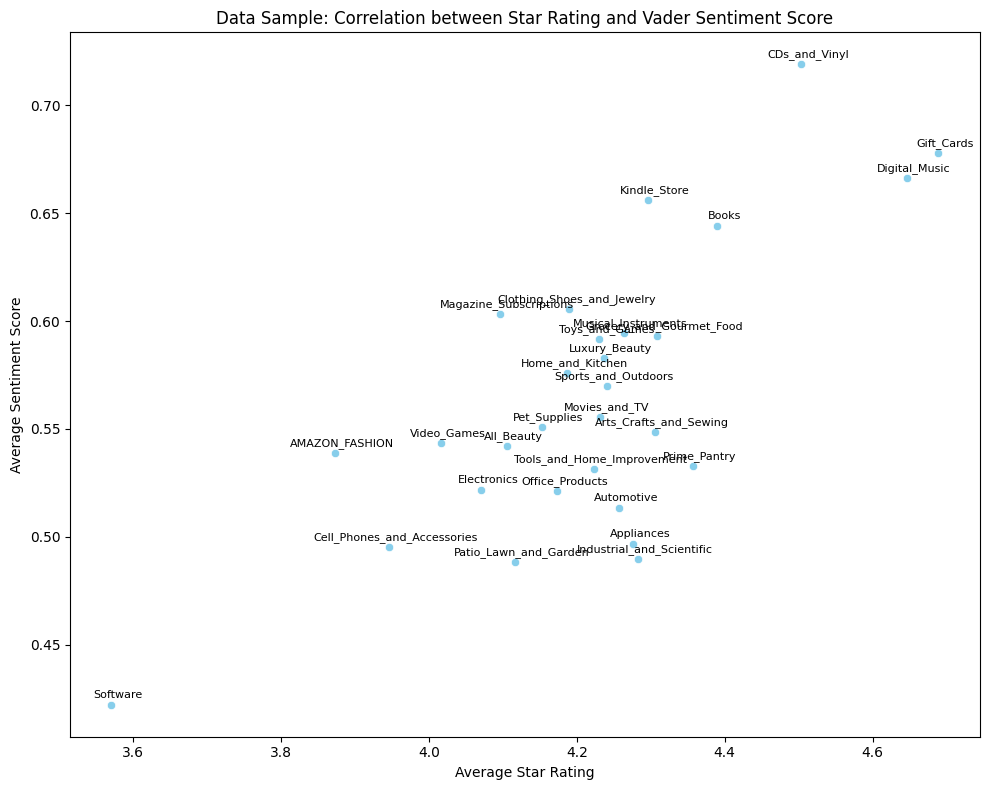

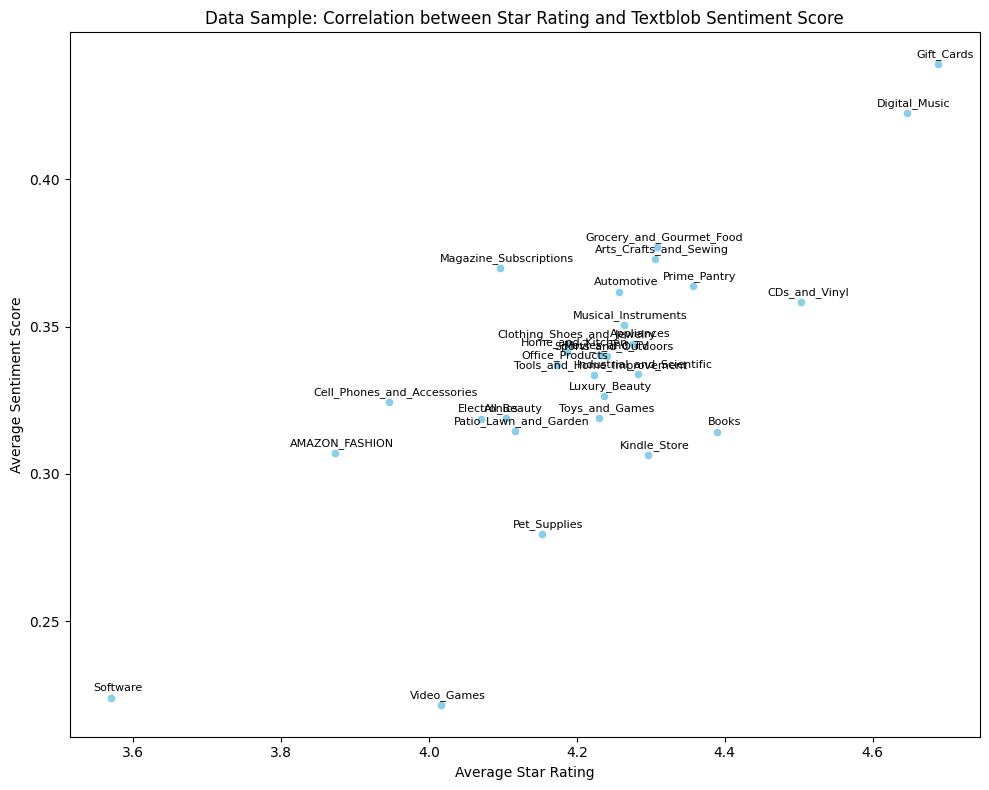

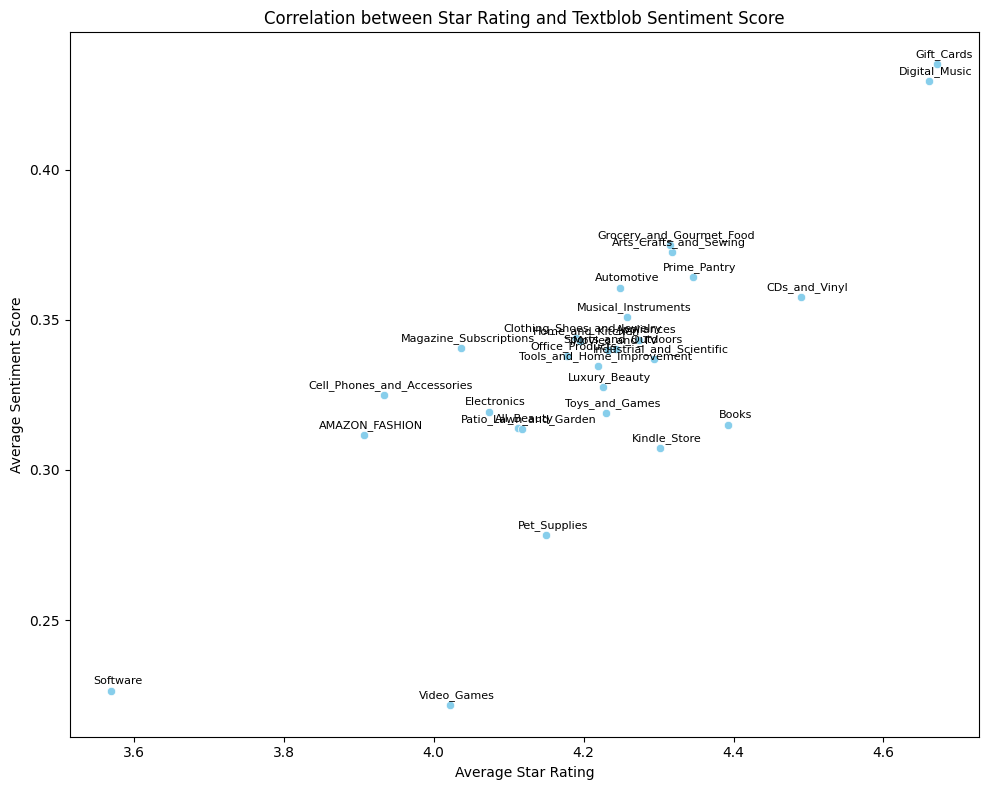

In [31]:
def plot_correlation_stars_sentiment(title, df_stars, df_sentiment):
    df_merged = df_stars.merge(df_sentiment, on='category', how='left')[['category', 'average_rating', 'average_sentiment']]

    # Plotting the stacked horizontal bar plot with pastel-toned colors
    plt.figure(figsize=(10, 8))
    ax1 = sns.scatterplot(x='average_rating', y='average_sentiment', data=df_merged, color="#87CEEB")

    # Annotate each point with the category name
    for i, row in df_merged.iterrows():
        ax1.annotate(row['category'], (row['average_rating'], row['average_sentiment']),
                     textcoords="offset points", xytext=(5, 5), ha='center', fontsize=8)


    # Customize plot labels and title
    ax1.set_xlabel('Average Star Rating')
    ax1.set_ylabel('Average Sentiment Score')
    ax1.set_title(title)

    # Tight layout and legend
    plt.tight_layout()

    # Show the plot
    plt.show()

data_sample_cat_stars = reduce_to_cat_stars(data_sample)
plot_correlation_stars_sentiment('Data Sample: Correlation between Star Rating and Vader Sentiment Score', data_sample_cat_stars, data_sample_vader_cat_sentiment)
plot_correlation_stars_sentiment('Data Sample: Correlation between Star Rating and Textblob Sentiment Score', data_sample_cat_stars, data_sample_textblob_cat_sentiment)

plot_correlation_stars_sentiment('Correlation between Star Rating and Textblob Sentiment Score', data_cat_stars, data_textblob_cat_sentiment)